In [1]:
# Import project dependencies

import pandas as pd
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import  word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,recall_score,precision_score
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from matplotlib import pyplot
from keras import backend as K
from keras.layers import MaxPool1D
from keras.models import Model

# glove vectorizer dependencies
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import io
import os

In [2]:
# Read csv dataset and save to df

filePath = 'TOTAL_TEXTS_SETOPATI.csv'
VALIDATION_SPLIT = 0.3
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300

df = pd.read_csv(filePath)
print("DataFrame Size: "+ str(df.size))

DataFrame Size: 520235


In [3]:
#Preprocessing {Remove Stop words using nltk}

stop_words = stopwords.words("nepali")
def string_manipulation(df,column)  : 
    df[column] = df[column].apply(lambda x: re.sub('[।(),०-९<<?!,—,–,/,’,‘,:,\u200d]', '', x))
    df[column] = df[column].apply(lambda x: " ".join([i for i in x.split()if i not in (stop_words)]))
    return df
Data = string_manipulation(df,"text")

In [4]:
# convert word into vector

print('Indexing word vectors.')
embeddings_dict = {}

# Used NPVec1: Word Embeddings for Nepali for glove from [https://github.com/nowalab/nepali-word-embeddings]
# processed.glove.txt, processed_normalized_stemmed.glove 

with open("processed.glove", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

print('Found %s word vectors.' % len(embeddings_dict))

Indexing word vectors.
Found 663564 word vectors.


In [5]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
# second, prepare text samples and their labels
print('Processing text dataset')

newsTexts = Data['text'].tolist()
labels_index = {}  # dictionary mapping label name to numeric id
labels = [] # list of label ids
allCategoryDataList = Data['catagory']

indexCount = 0
for category in allCategoryDataList.unique():
    labels_index[category] = indexCount
    indexCount = indexCount + 1

for category in allCategoryDataList.tolist():
    labels.append(labels_index[category])
        
print('Found %s news texts.' % len(newsTexts))
print('Found %s news labels.' % len(labels))


Processing text dataset
Found 104047 news texts.
Found 104047 news labels.


In [7]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(newsTexts)
sequences = tokenizer.texts_to_sequences(newsTexts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labelsCategorical = to_categorical(np.asarray(labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labelsCategorical.shape)
print('label tensor:', labelsCategorical[0])

# split the data into a training set(70%) and a validation set(30%)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
finalLabels = labelsCategorical[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = finalLabels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = finalLabels[-num_validation_samples:]

Found 899236 unique tokens.
Shape of data tensor: (104047, 1000)
Shape of label tensor: (104047, 63)
label tensor: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print("done")

Preparing embedding matrix.
done


In [9]:
# print('Training model. CNN CNN Model.')

# # train a 1D convnet with global maxpooling
# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)

# x = Conv1D(128, 5, activation='relu')(embedded_sequences)
# x1 = Dropout(0.2)(x)
# x2 = MaxPooling1D(5)(x1)
# x3 = Conv1D(128, 5, activation='relu')(x2)
# x4 = Dropout(0.3)(x3)
# x5 = MaxPooling1D(5)(x4)
# x6 = Conv1D(128, 5, activation='relu')(x5)
# x7 = GlobalMaxPooling1D()(x6)
# x8 = Dense(128, activation='relu')(x7)
# print("len labels:", str(len(labels_index)))
# preds = Dense(len(labels_index), activation='softmax')(x8)

# print("Preds shape: ", preds.shape)
# print("sequence_input shape: ", sequence_input.shape)

# model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc', f1_m, precision_m, recall_m])

# print("Shape of x_train: ", x_train.shape)
# print("Shape of y_train: ", y_train.shape)
# print("Shape of x_val: ", x_val.shape)
# print("Shape of y_val: ", y_val.shape)
# print(model.output_shape)
# model.summary()


# history = model.fit(x_train, y_train,
#           batch_size=128,
#           epochs=15,
#           validation_data=(x_val, y_val))

In [10]:
# # print('Training model. CNN biLstm Model.')
# from keras.models import Sequential
# from keras.layers import Embedding
# from tensorflow.keras.layers import Bidirectional
# from keras.layers import LSTM
# from keras.layers import Activation


# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)

# model = Sequential()
# model.add(embedding_layer)
# # model.add(Embedding(embedded_sequences, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length = maxlen, trainable=False))
# model.add(Dropout(0.2)) # embedding dropouts
# model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, activation = 'tanh'))) # weight drop on recurrent layers using recurrent_dropout
# model.add(GlobalMaxPooling1D())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(63))
# model.add(Activation('sigmoid'))

# model.summary()
# model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam', metrics = ['accuracy'])
    

# # train the model
# # model.fit(x_train, y_train, X_val=x_val, y_val=y_val,
# #     epoch_num=15, optimizer='adam', verbose=True)
# history = model.fit(x_train, y_train,
#           batch_size=128,
#           epochs=15,
#           validation_data=(x_val, y_val))

In [11]:
# CNN Bilstm attention
from keras.layers import Input, Dense, LSTM, concatenate,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model
from keras_self_attention import SeqSelfAttention

from tensorflow.keras.layers import Attention
from keras.layers.core import *
from keras.models import *

lstm_units = 64
SINGLE_ATTENTION_VECTOR = False
# def attention_3d_block(inputs):
#     # inputs.shape = (batch_size, time_steps, input_dim)
#     input_dim = int(inputs.shape[2])
#     a = inputs
#     #a = Permute((2, 1))(inputs)
#     #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
#     a = Dense(input_dim, activation='softmax')(a)
#     if SINGLE_ATTENTION_VECTOR:
#         a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
#         a = RepeatVector(input_dim)(a)
#     a_probs = Permute((1, 2), name='attention_vec')(a)

#     output_attention_mul = concatenate([inputs, a_probs])
#     return output_attention_mul

def attention_model():
#     inputs = Input(shape= x_train.shape)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    
    x = Conv1D(filters = 128, kernel_size = 5, activation = 'relu')(embedded_sequences)  #, padding = 'same'
    x = MaxPooling1D(5)(x)
    x = Dropout(0.2)(x)
#     lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
#     lstm_out = Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, activation = 'tanh'))(x)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(x)
    lstm_out = Dropout(0.2)(lstm_out)
    attention_mul = SeqSelfAttention(attention_width=15, attention_activation='relu',name='Attention')(lstm_out)
    attention_mul = Flatten()(attention_mul)

    output = Dense(63, activation='sigmoid')(attention_mul)
    model = Model(inputs=[sequence_input], outputs=output)
    return model


m = attention_model()
m.summary()
m.compile(optimizer='adam', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 300)         6000000   
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 199, 128)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 199, 256)         263168    
 l)                                                          

In [18]:
history = m.fit([x_train], y_train, epochs=200, batch_size=64, validation_split=0.3, validation_data=(x_val, y_val))

Epoch 1/200
1139/1139 [==============================] - 727s 638ms/step - loss: 0.0036 - acc: 0.8540 - f1_m: 0.8549 - precision_m: 0.9024 - recall_m: 0.8132 - val_loss: 0.0061 - val_acc: 0.7557 - val_f1_m: 0.7543 - val_precision_m: 0.7973 - val_recall_m: 0.7165
Epoch 2/200
1139/1139 [==============================] - 741s 651ms/step - loss: 0.0034 - acc: 0.8659 - f1_m: 0.8646 - precision_m: 0.9090 - recall_m: 0.8254 - val_loss: 0.0060 - val_acc: 0.7557 - val_f1_m: 0.7558 - val_precision_m: 0.7985 - val_recall_m: 0.7184
Epoch 3/200
1139/1139 [==============================] - 725s 637ms/step - loss: 0.0033 - acc: 0.8711 - f1_m: 0.8716 - precision_m: 0.9137 - recall_m: 0.8341 - val_loss: 0.0064 - val_acc: 0.7467 - val_f1_m: 0.7443 - val_precision_m: 0.7799 - val_recall_m: 0.7127
Epoch 4/200
1139/1139 [==============================] - 2056s 2s/step - loss: 0.0031 - acc: 0.8803 - f1_m: 0.8801 - precision_m: 0.9196 - recall_m: 0.8447 - val_loss: 0.0061 - val_acc: 0.7561 - val_f1_m: 0.7537

1139/1139 [==============================] - 827s 726ms/step - loss: 0.0017 - acc: 0.9369 - f1_m: 0.9344 - precision_m: 0.9539 - recall_m: 0.9162 - val_loss: 0.0068 - val_acc: 0.7475 - val_f1_m: 0.7496 - val_precision_m: 0.7791 - val_recall_m: 0.7230
Epoch 33/200
1139/1139 [==============================] - 927s 814ms/step - loss: 0.0017 - acc: 0.9372 - f1_m: 0.9362 - precision_m: 0.9555 - recall_m: 0.9182 - val_loss: 0.0068 - val_acc: 0.7488 - val_f1_m: 0.7483 - val_precision_m: 0.7825 - val_recall_m: 0.7178
Epoch 34/200
1139/1139 [==============================] - 811s 712ms/step - loss: 0.0017 - acc: 0.9384 - f1_m: 0.9376 - precision_m: 0.9568 - recall_m: 0.9197 - val_loss: 0.0068 - val_acc: 0.7501 - val_f1_m: 0.7513 - val_precision_m: 0.7831 - val_recall_m: 0.7228
Epoch 35/200
1139/1139 [==============================] - 837s 735ms/step - loss: 0.0017 - acc: 0.9384 - f1_m: 0.9374 - precision_m: 0.9565 - recall_m: 0.9195 - val_loss: 0.0069 - val_acc: 0.7529 - val_f1_m: 0.7527 - val_

1139/1139 [==============================] - 753s 661ms/step - loss: 0.0015 - acc: 0.9471 - f1_m: 0.9460 - precision_m: 0.9620 - recall_m: 0.9309 - val_loss: 0.0070 - val_acc: 0.7460 - val_f1_m: 0.7474 - val_precision_m: 0.7776 - val_recall_m: 0.7203
Epoch 64/200
1139/1139 [==============================] - 761s 668ms/step - loss: 0.0015 - acc: 0.9465 - f1_m: 0.9448 - precision_m: 0.9613 - recall_m: 0.9294 - val_loss: 0.0070 - val_acc: 0.7438 - val_f1_m: 0.7460 - val_precision_m: 0.7812 - val_recall_m: 0.7147
Epoch 65/200
1139/1139 [==============================] - 751s 659ms/step - loss: 0.0015 - acc: 0.9465 - f1_m: 0.9455 - precision_m: 0.9617 - recall_m: 0.9304 - val_loss: 0.0069 - val_acc: 0.7444 - val_f1_m: 0.7466 - val_precision_m: 0.7798 - val_recall_m: 0.7171
Epoch 66/200
1139/1139 [==============================] - 753s 661ms/step - loss: 0.0015 - acc: 0.9475 - f1_m: 0.9462 - precision_m: 0.9623 - recall_m: 0.9310 - val_loss: 0.0069 - val_acc: 0.7474 - val_f1_m: 0.7501 - val_

1139/1139 [==============================] - 733s 644ms/step - loss: 0.0013 - acc: 0.9525 - f1_m: 0.9511 - precision_m: 0.9653 - recall_m: 0.9377 - val_loss: 0.0070 - val_acc: 0.7497 - val_f1_m: 0.7496 - val_precision_m: 0.7772 - val_recall_m: 0.7248
Epoch 95/200
1139/1139 [==============================] - 736s 647ms/step - loss: 0.0014 - acc: 0.9519 - f1_m: 0.9502 - precision_m: 0.9646 - recall_m: 0.9367 - val_loss: 0.0071 - val_acc: 0.7500 - val_f1_m: 0.7514 - val_precision_m: 0.7708 - val_recall_m: 0.7336
Epoch 96/200
1139/1139 [==============================] - 732s 642ms/step - loss: 0.0013 - acc: 0.9531 - f1_m: 0.9513 - precision_m: 0.9654 - recall_m: 0.9380 - val_loss: 0.0071 - val_acc: 0.7468 - val_f1_m: 0.7491 - val_precision_m: 0.7704 - val_recall_m: 0.7297
Epoch 97/200
1139/1139 [==============================] - 726s 638ms/step - loss: 0.0013 - acc: 0.9534 - f1_m: 0.9521 - precision_m: 0.9667 - recall_m: 0.9384 - val_loss: 0.0071 - val_acc: 0.7464 - val_f1_m: 0.7469 - val_

Epoch 125/200
1139/1139 [==============================] - 739s 649ms/step - loss: 0.0013 - acc: 0.9543 - f1_m: 0.9529 - precision_m: 0.9666 - recall_m: 0.9401 - val_loss: 0.0070 - val_acc: 0.7475 - val_f1_m: 0.7503 - val_precision_m: 0.7776 - val_recall_m: 0.7257
Epoch 126/200
1139/1139 [==============================] - 745s 654ms/step - loss: 0.0013 - acc: 0.9547 - f1_m: 0.9535 - precision_m: 0.9672 - recall_m: 0.9407 - val_loss: 0.0070 - val_acc: 0.7491 - val_f1_m: 0.7507 - val_precision_m: 0.7806 - val_recall_m: 0.7238
Epoch 127/200
1139/1139 [==============================] - 740s 650ms/step - loss: 0.0013 - acc: 0.9547 - f1_m: 0.9537 - precision_m: 0.9676 - recall_m: 0.9406 - val_loss: 0.0071 - val_acc: 0.7449 - val_f1_m: 0.7479 - val_precision_m: 0.7842 - val_recall_m: 0.7155
Epoch 128/200
1139/1139 [==============================] - 785s 689ms/step - loss: 0.0012 - acc: 0.9559 - f1_m: 0.9544 - precision_m: 0.9672 - recall_m: 0.9424 - val_loss: 0.0071 - val_acc: 0.7453 - val_f1

Epoch 156/200
1139/1139 [==============================] - 753s 661ms/step - loss: 0.0012 - acc: 0.9568 - f1_m: 0.9553 - precision_m: 0.9681 - recall_m: 0.9433 - val_loss: 0.0071 - val_acc: 0.7473 - val_f1_m: 0.7513 - val_precision_m: 0.7812 - val_recall_m: 0.7244
Epoch 157/200
1139/1139 [==============================] - 793s 696ms/step - loss: 0.0012 - acc: 0.9578 - f1_m: 0.9561 - precision_m: 0.9685 - recall_m: 0.9445 - val_loss: 0.0070 - val_acc: 0.7511 - val_f1_m: 0.7518 - val_precision_m: 0.7779 - val_recall_m: 0.7282
Epoch 158/200
1139/1139 [==============================] - 789s 693ms/step - loss: 0.0012 - acc: 0.9576 - f1_m: 0.9564 - precision_m: 0.9688 - recall_m: 0.9448 - val_loss: 0.0071 - val_acc: 0.7463 - val_f1_m: 0.7473 - val_precision_m: 0.7816 - val_recall_m: 0.7168
Epoch 159/200
1139/1139 [==============================] - 735s 646ms/step - loss: 0.0012 - acc: 0.9570 - f1_m: 0.9559 - precision_m: 0.9679 - recall_m: 0.9445 - val_loss: 0.0071 - val_acc: 0.7467 - val_f1

Epoch 187/200
1139/1139 [==============================] - 751s 659ms/step - loss: 0.0012 - acc: 0.9592 - f1_m: 0.9578 - precision_m: 0.9699 - recall_m: 0.9465 - val_loss: 0.0071 - val_acc: 0.7479 - val_f1_m: 0.7496 - val_precision_m: 0.7814 - val_recall_m: 0.7210
Epoch 188/200
1139/1139 [==============================] - 748s 656ms/step - loss: 0.0012 - acc: 0.9587 - f1_m: 0.9572 - precision_m: 0.9695 - recall_m: 0.9457 - val_loss: 0.0071 - val_acc: 0.7473 - val_f1_m: 0.7482 - val_precision_m: 0.7820 - val_recall_m: 0.7179
Epoch 189/200
1139/1139 [==============================] - 750s 659ms/step - loss: 0.0012 - acc: 0.9585 - f1_m: 0.9575 - precision_m: 0.9698 - recall_m: 0.9459 - val_loss: 0.0071 - val_acc: 0.7466 - val_f1_m: 0.7469 - val_precision_m: 0.7772 - val_recall_m: 0.7196
Epoch 190/200
1139/1139 [==============================] - 748s 657ms/step - loss: 0.0012 - acc: 0.9591 - f1_m: 0.9581 - precision_m: 0.9702 - recall_m: 0.9467 - val_loss: 0.0072 - val_acc: 0.7448 - val_f1

In [13]:
# BiLstm CNN Model 
# from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
# from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
# from keras.optimizers import Adam

# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ))
# x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],trainable = False)(sequence_input)
# x = SpatialDropout1D(0.2)(x)
# x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
# x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
# avg_pool = GlobalAveragePooling1D()(x)
# max_pool = GlobalMaxPooling1D()(x)
# x = concatenate([avg_pool, max_pool]) 
# # x = Dense(128, activation='relu')(x)
# # x = Dropout(0.1)(x)
# preds = Dense(63, activation="sigmoid")(x)
# model = Model(sequence_input, preds)
# model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])
# model.summary()
# history = model.fit(x_train, y_train, epochs = 20, validation_split=0.1, shuffle=True, batch_size=64)

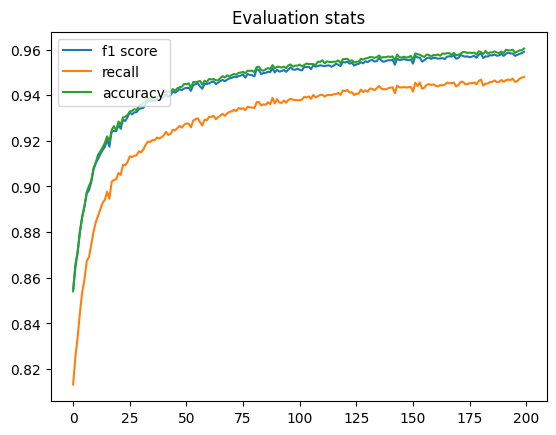

In [19]:
# plot metrics
pyplot.plot(history.history["f1_m"],  label="f1 score")

pyplot.plot(history.history["recall_m"], label="recall")
pyplot.plot(history.history['acc'] , label="accuracy")
pyplot.title('Evaluation stats')
pyplot.legend(loc="upper left")
pyplot.show()

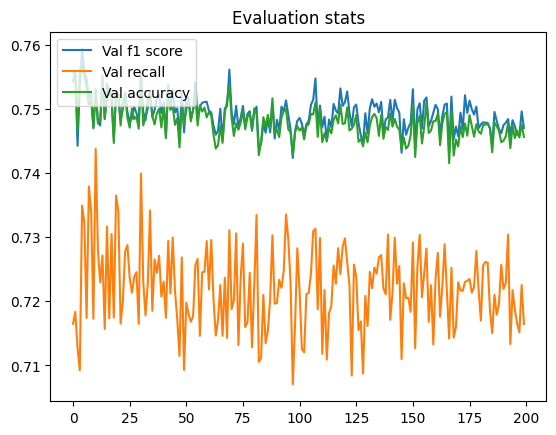

In [21]:
pyplot.plot(history.history["val_f1_m"],  label="Val f1 score")

pyplot.plot(history.history["val_recall_m"], label="Val recall")
pyplot.plot(history.history['val_acc'] , label="Val accuracy")

pyplot.title('Evaluation stats')
pyplot.legend(loc="upper left")
pyplot.show()

In [15]:
# serialize model to JSON
model_json = m.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
# load json and create model
from keras.models import model_from_json 

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_val, y_val, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

ValueError: Unknown layer: SeqSelfAttention. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.